# 05.04 adaptive quadrature

##### code, support for section text


In [ ]:
if True: # settings for the people
  import matplotlib.pyplot as plt
  import numpy as np
  import scipy as sp
  from sympy import *


###### code, adaptive

In [ ]:
def adaptive_trapezoid(af,aa,ab,ah0,aeps,all=False,debug=False):
  """
  af : function to integrate
  aa : subinterval, left bound
  ab : subinterval, right bound
  h0 : interval length
  aeps : error bound
  all : amount of return data
  debug : guess, alright?
  returns : approximate integral, number of panels, midpoints of panels
  """
  count = 0
  midpoints = []

  a = aa; b = ab
  c = (a + b)/2
  fa = af(a); fb = af(b); fc = af(c);
  s_ab = (fa + fb)*(b - a)/2
  s_ac = (fa + fc)*(c - a)/2
  s_cb = (fc + fb)*(b - c)/2
  if abs(s_ab -(s_ac+s_cb)) < 3*aeps*(b-a)/(ah0):
    # accept approximation over [aa,ab]
    if debug: # for parallel with adaptive simpsons
      print(f"  f = ({fa},{fc},{fb})")
      print(f"[{a},{b}] = {s_ab} ? {s_ac + s_cb} = {s_ac} + {s_cb}")
    if all:
      count += 2
      midpoints.append(c)
  else:
    # recurse
    if all: # keep count
      s_ac,count_ac,midpoint_ac = adaptive_trapezoid(af,a,c,ah0,aeps,all,debug=debug)
      s_cb,count_cb,midpoint_cb = adaptive_trapezoid(af,c,b,ah0,aeps,all,debug=debug)
      count += count_ac + count_cb
      midpoints = midpoints + midpoint_ac + midpoint_cb
    else:
      s_ac = adaptive_trapezoid(af,a,c,ah0,aeps,debug=debug)
      s_cb = adaptive_trapezoid(af,c,b,ah0,aeps,debug=debug)

  s_ab = s_ac + s_cb
  if all:
    return s_ab,count,midpoints
  else:
    return s_ab


In [ ]:
def adaptive_simpson(af,aa,ab,ah0,aeps,all=False,debug=False):
  """
  af : function to integrate
  aa : subinterval, left bound
  ab : subinterval, right bound
  ah0 : interval length
  aeps : error bound
  all : amount of return data
  debug : guess, alright?
  returns : approximate integral, number of panels, midpoints of panels
  """
  count = 0
  midpoints = []

  a = aa; b = ab
  c = (a + b)/2
  fa = af(a); fb = af(b); fc = af(c);
  # 3rd points for simpsons parabolic fit
  m1 = (c + a)/2; m2 = (b + c)/2
  fm1 = af(m1); fm2 = af(m2)

  s_ab = (fa + 4*fc  + fb)*(b - a)/2/3
  s_ac = (fa + 4*fm1 + fc)*(c - a)/2/3
  s_cb = (fc + 4*fm2 + fb)*(b - c)/2/3
  if abs(s_ab -(s_ac+s_cb)) < 15*aeps*(b-a)/(ah0):
    if debug:
      print(f"  f = ({fa},{fm1},{fc},{fm2},{fb})")
      print(f"[{a},{b}] = {s_ab} ? {s_ac + s_cb} = {s_ac} + {s_cb}")
    # accept approximation over [aa,ab]
    if all:
      count += 2
      midpoints.append(c)
  else:
    # recurse
    if all: # keep count
      s_ac,count_ac,midpoint_ac = adaptive_simpson(af,a,c,ah0,aeps,all,debug=debug)
      s_cb,count_cb,midpoint_cb = adaptive_simpson(af,c,b,ah0,aeps,all,debug=debug)
      count += count_ac + count_cb
      midpoints = midpoints + midpoint_ac + midpoint_cb
    else:
      s_ac = adaptive_simpson(af,a,c,ah0,aeps,debug=debug)
      s_cb = adaptive_simpson(af,c,b,ah0,aeps,debug=debug)

  s_ab = s_ac + s_cb
  if all:
    return s_ab,count,midpoints
  else:
    return s_ab


###### code, examples

In [ ]:
# examples 12,13: integrate y(t) = 1 + sin e³ᵗ over t ϵ [-1,1]

def ex12(TOL=5e-3,displayScipy=True,displaySympy=False):
  '''
  TOL : tolerance
  '''

  # prob def
  #TOL = 5e-3
  f = lambda x: 1 + np.sin(np.exp(3*x))
  xx = (-1,1)

  # system benchmark
  if displayScipy:
    s = sp.integrate.quad(f,xx[0],xx[1])
    print() # spacer
    print(f"scipy: {s[0]:.10f} with error {s[1]:.10}.")

  if displaySympy: # sympy
    # define problem
    x_sym = Symbol('x'); f_sym = 1 + sin(exp(3*x_sym))
    # integrate
    #isymbol = integrate(f_sym,x_sym)
    inumber = integrate(f_sym,(x_sym,xx[0],xx[1]))
    # display
    print(f"sympy: {inumber} \u2248 {N(inumber,11)}.") # bc total vs decimal

  print() # spacer
  # adaptive trapezoid
  s_trapezoid,count_trapezoid,midpoints_trapezoid = adaptive_trapezoid(f,xx[0],xx[1],xx[1]-xx[0],TOL,all=True)
  print(f"trapezoid: {s_trapezoid:.6f} w {count_trapezoid:3d} panels for tolerance {TOL}.")

  # adaptive simpsons
  s_simpsons,count_simpsons,midpoints_simpsons = adaptive_simpson(f,xx[0],xx[1],xx[1]-xx[0],TOL,all=True)
  print(f" simpsons: {s_simpsons:.6f} w {count_simpsons:3d} panels for tolerance {TOL}.")

  # plot
  xs_dis = np.linspace(xx[0],xx[1],1001)
  plt.plot(xs_dis,f(xs_dis))
  plt.scatter(midpoints_trapezoid,[0]*len(midpoints_trapezoid),marker=".")
  plt.scatter(midpoints_simpsons,[0]*len(midpoints_simpsons),marker="|")

  # plot, show
  print() # spacer
  plt.show()


## 0 intro

"quadrature" $\equiv$ "calculating area".

**previously**: integration methods that used (two) end points with $f''$ error term then used three points with $f'''$ error term then intervals without one end point (ie, "open"); extrapolated with extra, evenly spaced partitions; combined those ideas.

**unsurprisingly**: the next step is to do away with "evenly spaced".

1. higher order error may complicate choosing $h$ to meet that error;
<br/>
if input is data, there is no function for derivatives; and
<br/>
<br/>

2. what happens if the function or data behaves differently over given domain?

adaptive quadrature uses error formulas to inform step sizes per interval. eg, in the images below, step size $h$ decreases in magnitude / increases in frequency with increase in rate of change. ie, increasing partitions decreases error.

consider the trapezoid rule which covers area $S$ over interval $[a,b]$ where $h = b-a$ and $a<c_0<b$.

$$\int_a^b f(x)dx = S_{[a,b]} - h^3\frac{f''(c_0)}{12}.$$

split the interval at midpoint $c$ with $a<c_1<c$, $c<c_2<b$ and $c_1<c_3<c_2$ (gIVT).

\begin{align}
  \int_a^b f(x)dx &= S_{[a,c]}
    - \frac{h^3}{8}\frac{f''(c_1)}{12}
    + S_{[c,b]}- \frac{h^3}{8}\frac{f''(c_2)}{12} \\
  \\
  &= S_{[a,c]} + S_{[c,b]} - \frac{h^3}{4}\frac{f''(c_3)}{12}.
\end{align}

sub out the integrals,

\begin{align}
  S_{[a,b]} - (S_{[a,c]} + S_{[c,b]})
    &= h^3\frac{f''(c_0)}{12} -\frac{h^3}{4}\frac{f''(c_3)}{12} \\
  \\
  &\Downarrow \quad f''(c_3) \approx f''(c_0) \\
  \\
  &\approx \frac{3}{4}h^3\frac{f''(c_3)}{12}.
\end{align}

algebra and one approximation removed the integrals, :). and error <i>between the two methods</i> is the last approximation previous. ie, two half-intervals improves error by diminishing to the already introduced factor of $\tfrac{1}{2^n}$; alternatively, that the error of the half-partitions is $\tfrac{1}{3}$ of the difference of error between the two methods.

explicitly, the idea is to do that as needed over subintervals. ie, maybe one subinterval meets a predetermined maximum error without the extrapolation of further partitions but another needs improvement with them.

#### algorithm, adapative quadrature


```
# adaptive quadrature, trapezoid

def f_aquad(af,aa,ab,ah0,aeps):
  c = (aa+ab)/2
  s_ab = (ab-aa)/2*(af(aa) + af(ab))
  s_ac = (c-aa)/2*(af(aa) + af(c))
  s_cb = (ab-c)/2*(af(c) + af(ab))
  if abs(s_ab -(s_ac+s_cb)) < 3*aeps*(ab-aa)/(ah0):
    # accept approximation over [aa,ab]
    pass
  else:
    # recurse
    s_ac = f_aquad(af,aa,c,ah0)
    s_cb = f_aquad(af,c,ab,ah0)
  s_ab = s_ac + s_cb
  return s_ab

s = f_aquad(f,a,b,b-a,TOL)
```

##### example 12

use adaptive quadrature to approximate the integral

$$\int_{-1}^1 (1 + sin \text{ }e^{3x}) \text{ }dx.$$



scipy: 2.5008091103 with error 9.407896684e-11.

trapezoid: 2.501860 w 140 panels for tolerance 0.005.
 simpsons: 2.500212 w  18 panels for tolerance 0.005.



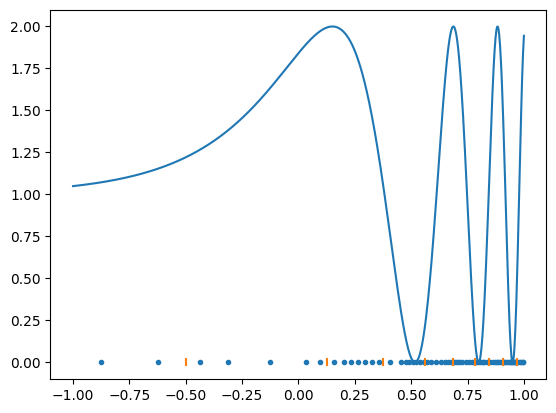

In [ ]:
ex12(5e-3) # and eg 13


#### adaptive simpsons

a similar derivation against simpson yields:

\begin{align}
  \int_a^b f(x) \text{ }dx &= S_{[a,b]} - \frac{h^3}{90}f^{(iv)}(c_0) \\
  \\
  \int_a^b f(x) \text{ }dx &= S_{[a,c]} - \frac{(\frac{h}{2})^3}{90}f^{(iv)}(c_1) + S_{[c,b]} - \frac{(\frac{h}{2})^3}{90}f^{(iv)}(c_2)\\
  &= S_{[a,c]} + S_{[c,b]} - \frac{2h^3}{32\cdot 90}f(^{(iv)}(c_3) \\
  \\
  &\Downarrow \\
  \\
  S_{[a,b]} - (S_{[a,c]} + S_{[c,b]}) &= h^5\frac{f^{(iv)}(c_0)}{90} - \frac{h^5}{16}\frac{f^{(iv)}(c_3)}{90} \approx \frac{15}{16}h^3\frac{f^{(iv)}(c_0)}{90}
\end{align}

where $f^{(iv)}(c_3) \approx f^{(iv)}(c_0)$. ie, "15" replaces "3" as TOL in adpative algorithm above although "10" is more commonly used for a more conservative algorithm.

adaptive simpsons applied to $\int_{-1}^1 (1+sin(e^{3x}))dx$ is the source for sauer, 2nd, figure 5 above.


## resources

* quadrature [@wiki](https://en.wikipedia.org/wiki/Numerical_integration#Connection_with_differential_equations), [squaring the circle](https://en.wikipedia.org/wiki/Squaring_the_circle)